In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

## Load the train and validation datasets

In [5]:
root = '../KuaiRec 2.0/'

# Training data
train = pd.read_csv(root + "data_exports/joined_train_data_segmented.csv")

# Validation data
val = pd.read_csv(root + "data_exports/joined_val_data.csv")

# Test data
# test = pd.read_csv(root + "test_data.csv")

print(f'Total number of training data: {len(train)}')
print(f'Total number of validation data: {len(val)}')
# print(f'Total number of test data: {len(test)}')

Total number of training data: 2552082
Total number of validation data: 1376299


In [6]:
# Convert to datetime
train['time'] = pd.to_datetime(train['time'])
val['time'] = pd.to_datetime(val['time'])
# test['time'] = pd.to_datetime(test['time'])

In [9]:
train.head()

,user_id,video_id,time,watch_ratio,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,fans_user_num,...,avg_daily_watch_time,top_3_categories,cluster,News_Politics,Auto_Tech,Lifestyle,Sports_Fitness,Entertainment,Culture,Others
0,14,148,2020-07-05 05:27:48.378,0.722103,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1
1,14,183,2020-07-05 05:28:00.057,1.907377,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1
2,14,3649,2020-07-05 05:29:09.479,2.063311,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1
3,14,5262,2020-07-05 05:30:43.285,0.566388,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1
4,14,8234,2020-07-05 05:35:43.459,0.418364,full_active,0,0,1,73,6,...,8.360719e+12,"['Car', 'Pets', 'Real estate家居']",0,0,1,1,0,0,0,1


In [ ]:
# Segregate by 
# 'cluster'

# One hot encode
# 'user_active_degree', 'time_period'

# Embedding?
# 'video_tag_name'

# Remove
# 'author_id', 'video_type', 
# Are all texts, cant fit into NN
#     'manual_cover_text',
#    'caption', 'topic_tag', 'first_level_category_name',
#    'second_level_category_name', 'third_level_category_name',
#    'english_caption', 'english_first_level_category_name',
#    'english_second_level_category_name',
#    'english_third_level_category_name', 'english_topic_tag'
# 'top_3_categories' -> use the wider categories

# Exclude in training (use in time infused segment)
# 'time'

train['user_active_degree'].value_counts(dropna=False)

full_active      2197006
high_active       313625
UNKNOWN            37820
middle_active       3631
Name: user_active_degree, dtype: int64

In [10]:
train.columns

Index(['user_id', 'video_id', 'time', 'watch_ratio', 'user_active_degree',
       'is_lowactive_period', 'is_live_streamer', 'is_video_author',
       'follow_user_num', 'fans_user_num', 'friend_user_num', 'register_days',
       'author_id', 'video_type', 'video_tag_name', 'video_duration',
       'show_cnt', 'play_cnt', 'play_duration', 'like_cnt', 'comment_cnt',
       'share_cnt', 'follow_cnt', 'collect_cnt', 'manual_cover_text',
       'caption', 'topic_tag', 'first_level_category_name',
       'second_level_category_name', 'third_level_category_name',
       'english_caption', 'english_first_level_category_name',
       'english_second_level_category_name',
       'english_third_level_category_name', 'english_topic_tag', 'is_new_user',
       'total_connections', 'is_content_creator', 'hour', 'day_of_week',
       'watch_frequency', 'is_weekend_interaction', 'is_weekend',
       'time_period', 'count_afternoon_views', 'count_evening_views',
       'count_midnight_views', 'count_m

## Preprocessing for feeding into Neural Netork portion of NCF

In [220]:
# One hot encode 'user_active_degree', 'time_period'
train_ohe = pd.get_dummies(train, columns=['user_active_degree', 'time_period'])

# Remove the column for user_active_degree = UNKNOWN
train_ohe = train_ohe.drop(columns=['user_active_degree_UNKNOWN'])

In [221]:
# Remove 'author_id', 'video_type' (all 'NORMAL) and video caption/category columns. For video features, we are using the 
# regrouped category mappings which we have already one hot encoded from the feature engineering stage

train_ohe = train_ohe.drop(columns=['author_id', 'video_type', 
                                    'video_tag_name', 
                                    'manual_cover_text', 'caption', 'topic_tag', 
                                    'first_level_category_name', 'second_level_category_name', 'third_level_category_name',
                                    'english_caption', 'english_first_level_category_name',
                                    'english_second_level_category_name',
                                    'english_third_level_category_name', 'english_topic_tag',
                                    'top_3_categories'
                                    ])

## Create the DataLoader

In [228]:
# Test on cluster 0 first
train_filtered = train_ohe[train_ohe['cluster'] == 0]

In [229]:
train_filtered.columns

Index(['user_id', 'video_id', 'time', 'watch_ratio', 'is_lowactive_period',
       'is_live_streamer', 'is_video_author', 'follow_user_num',
       'fans_user_num', 'friend_user_num', 'register_days', 'video_duration',
       'show_cnt', 'play_cnt', 'play_duration', 'like_cnt', 'comment_cnt',
       'share_cnt', 'follow_cnt', 'collect_cnt', 'is_new_user',
       'total_connections', 'is_content_creator', 'hour', 'day_of_week',
       'watch_frequency', 'is_weekend_interaction', 'is_weekend',
       'count_afternoon_views', 'count_evening_views', 'count_midnight_views',
       'count_morning_views', 'avg_daily_watch_time', 'cluster',
       'News_Politics', 'Auto_Tech', 'Lifestyle', 'Sports_Fitness',
       'Entertainment', 'Culture', 'Others', 'user_active_degree_full_active',
       'user_active_degree_high_active', 'user_active_degree_middle_active',
       'time_period_afternoon', 'time_period_evening', 'time_period_midnight',
       'time_period_morning'],
      dtype='object')

In [230]:
train_filtered[['follow_user_num',
       'fans_user_num', 'friend_user_num', 'register_days', 'video_duration',
       'show_cnt', 'play_cnt', 'play_duration', 'like_cnt', 'comment_cnt',
       'share_cnt', 'follow_cnt', 'collect_cnt']].describe()

train_filtered[['count_afternoon_views', 'count_evening_views', 'count_midnight_views',
       'count_morning_views', 'avg_daily_watch_time']].describe()

,count_afternoon_views,count_evening_views,count_midnight_views,count_morning_views,avg_daily_watch_time
count,483319.000000,483319.000000,483319.000000,483319.000000,4.833190e+05
mean,466.829268,286.960287,412.687625,636.119811,8.109965e+12
std,222.444819,182.647087,313.589031,251.818853,6.719419e+11
min,0.000000,0.000000,0.000000,0.000000,5.338066e+12
25%,319.000000,150.000000,118.000000,471.000000,7.776223e+12
50%,447.000000,271.000000,370.000000,626.000000,8.198831e+12
75%,618.000000,409.000000,654.000000,780.000000,8.570317e+12
max,1181.000000,868.000000,1252.000000,1561.000000,1.105953e+13


In [ ]:
# Convert 'video_duration' to from ms to minutes
train_filtered['video_duration'] = train_filtered['video_duration'] / 60000

# Convert 'play_duration' and 'avg_daily_watch_time' from ms to hours
train_filtered['play_duration'] = train_filtered['play_duration'] / 3600000
train_filtered['avg_daily_watch_time'] = train_filtered['avg_daily_watch_time'] / 3600000

# Convert counts to log scale
train_filtered[['show_cnt', 'play_cnt', 'like_cnt', 'comment_cnt', 'share_cnt', 'follow_cnt', 'collect_cnt']] = np.log1p(train_filtered[['show_cnt', 'play_cnt', 'like_cnt', 'comment_cnt', 'share_cnt', 'follow_cnt', 'collect_cnt']])

# Convert view counts to thousands
train_filtered[['count_afternoon_views', 'count_evening_views', 'count_midnight_views', 'count_morning_views']] = train_filtered[['count_afternoon_views', 'count_evening_views', 'count_midnight_views', 'count_morning_views']] / 1000

C:\Users\chong\AppData\Local\Temp\ipykernel_51328\453066862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['video_duration'] = train_filtered['video_duration'] / 60000
C:\Users\chong\AppData\Local\Temp\ipykernel_51328\453066862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['play_duration'] = train_filtered['play_duration'] / 3600000
C:\Users\chong\AppData\Local\Temp\ipykernel_51328\453066862.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [236]:
train_filtered[['follow_user_num',
       'fans_user_num', 'friend_user_num', 'register_days', 'video_duration',
       'show_cnt', 'play_cnt', 'play_duration', 'like_cnt', 'comment_cnt',
       'share_cnt', 'follow_cnt', 'collect_cnt']].describe()

train_filtered[['count_afternoon_views', 'count_evening_views', 'count_midnight_views',
       'count_morning_views', 'avg_daily_watch_time']].describe()

,count_afternoon_views,count_evening_views,count_midnight_views,count_morning_views,avg_daily_watch_time
count,483319.000000,483319.000000,483319.000000,483319.000000,4.833190e+05
mean,0.466829,0.286960,0.412688,0.636120,2.252768e+06
std,0.222445,0.182647,0.313589,0.251819,1.866505e+05
min,0.000000,0.000000,0.000000,0.000000,1.482796e+06
25%,0.319000,0.150000,0.118000,0.471000,2.160062e+06
50%,0.447000,0.271000,0.370000,0.626000,2.277453e+06
75%,0.618000,0.409000,0.654000,0.780000,2.380644e+06
max,1.181000,0.868000,1.252000,1.561000,3.072091e+06


In [237]:
class KuaiShouDataset(Dataset):
    def __init__(self, data, user_id_col, video_id_col, user_feature_cols, video_feature_cols, watch_ratio_col):
        self.user_feature_cols = user_feature_cols
        self.video_feature_cols = video_feature_cols

        # Initialise and fit LabelEncoders
        self.user_encoder = LabelEncoder()
        self.video_encoder = LabelEncoder()
        
        self.user_ids = torch.tensor(self.user_encoder.fit_transform(data[user_id_col]), dtype=torch.long)
        self.video_ids = torch.tensor(self.video_encoder.fit_transform(data[video_id_col]), dtype=torch.long)

        # Convert user and video features and watch ratios to tensors
        self.user_features = torch.tensor(data[user_feature_cols].values, dtype=torch.float32)
        self.video_features = torch.tensor(data[video_feature_cols].values, dtype=torch.float32)
        self.watch_ratios = torch.tensor(data[watch_ratio_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        return (self.user_ids[idx], self.video_ids[idx], 
                self.user_features[idx], self.video_features[idx], 
                self.watch_ratios[idx])

    def inverse_transform_user_ids(self, encoded_user_ids):
        """Decode encoded user IDs to original IDs."""
        return self.user_encoder.inverse_transform(encoded_user_ids)
    
    def inverse_transform_video_ids(self, encoded_video_ids):
        """Decode encoded video IDs to original IDs."""
        return self.video_encoder.inverse_transform(encoded_video_ids)

In [241]:
user_cols = ['is_lowactive_period',
                'is_live_streamer', 'is_video_author', 'follow_user_num',
                'fans_user_num', 'friend_user_num', 'register_days', 'is_new_user',
                'total_connections', 'is_content_creator', 'hour', 'day_of_week',
                'watch_frequency', 'is_weekend_interaction', 'is_weekend',
                'count_afternoon_views', 'count_evening_views', 'count_midnight_views',
                'count_morning_views', 
                # 'avg_daily_watch_time', 
                # 'cluster',
                'user_active_degree_full_active', 'user_active_degree_high_active', 'user_active_degree_middle_active',
                'time_period_afternoon', 'time_period_evening', 'time_period_midnight', 'time_period_morning'
            ]
video_cols = ['video_duration',
                'show_cnt', 'play_cnt', 
                # 'play_duration', 
                'like_cnt', 'comment_cnt',
                'share_cnt', 'follow_cnt', 'collect_cnt', 'News_Politics', 'Auto_Tech', 'Lifestyle', 'Sports_Fitness',
                'Entertainment', 'Culture', 'Others',
                ]
dataset_train = KuaiShouDataset(train_filtered, 'user_id', 'video_id', user_cols, video_cols, 'watch_ratio')

batch_size = 512

# Initialise the DataLoader
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

## Define the model architecture

In [256]:
class NCF(nn.Module):
    def __init__(self, num_users, num_videos, embedding_dim, num_user_features, num_video_features):
        super(NCF, self).__init__()
        
        # GMF Components for embeddings
        self.user_embeddings_gmf = nn.Embedding(num_users, embedding_dim)
        self.video_embeddings_gmf = nn.Embedding(num_videos, embedding_dim)

        # MLP Components for embeddings
        self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dim)
        self.video_embeddings_mlp = nn.Embedding(num_videos, embedding_dim)

        # MLP layers for user and video embeddings
        self.fc1_mlp = nn.Linear(2 * embedding_dim, 128)
        self.fc2_mlp = nn.Linear(128, 64)

        # MLP layers for user and video features
        self.user_features_fc = nn.Linear(num_user_features, embedding_dim)
        self.video_features_fc = nn.Linear(num_video_features, embedding_dim)

        # Final layers combining GMF, MLP for embeddings, and additional features
        self.fc1_combined = nn.Linear(embedding_dim + 64 + 2 * embedding_dim, 128)
        self.fc2_combined = nn.Linear(128, 1)

        # Apply weight initialization
    #     self._initialize_weights()

    # def _initialize_weights(self):
    #     # Xavier initialization for fully connected layers
    #     nn.init.xavier_normal_(self.fc1_mlp.weight)
    #     nn.init.xavier_normal_(self.fc2_mlp.weight)
    #     nn.init.xavier_normal_(self.fc1_combined.weight)
    #     nn.init.xavier_normal_(self.fc2_combined.weight)
        
    #     # Uniform initialization for embeddings
    #     nn.init.uniform_(self.user_embeddings_gmf.weight, -0.1, 0.1)
    #     nn.init.uniform_(self.video_embeddings_gmf.weight, -0.1, 0.1)
    #     nn.init.uniform_(self.user_embeddings_mlp.weight, -0.1, 0.1)
    #     nn.init.uniform_(self.video_embeddings_mlp.weight, -0.1, 0.1)

    #     # Bias initialization
    #     nn.init.zeros_(self.fc1_mlp.bias)
    #     nn.init.zeros_(self.fc2_mlp.bias)
    #     nn.init.zeros_(self.fc1_combined.bias)
    #     nn.init.zeros_(self.fc2_combined.bias)

    def forward(self, user_id, video_id, user_features, video_features, dropout=0.5):
        ##### GMF Embedding branch
        user_emb_gmf = self.user_embeddings_gmf(user_id)
        video_emb_gmf = self.video_embeddings_gmf(video_id)
        gmf_output = user_emb_gmf * video_emb_gmf   # dimension: (batch_size, embedding_dim)

        ##### MLP Embedding branch
        user_emb_mlp = self.user_embeddings_mlp(user_id)
        video_emb_mlp = self.video_embeddings_mlp(video_id)
        mlp_input = torch.cat([user_emb_mlp, video_emb_mlp], dim=-1) # dimension: (batch_size, 2 * embedding_dim)

        # First fully connected layer with BatchNorm and ReLU
        mlp_output = self.fc1_mlp(mlp_input)
        if self.training:
            mlp_output = nn.BatchNorm1d(128)(mlp_output)
        mlp_output = torch.relu(mlp_output)
        mlp_output = nn.Dropout(dropout)(mlp_output)

        # Second fully connected layer with BatchNorm and ReLU
        mlp_output = self.fc2_mlp(mlp_output)
        if self.training:
            mlp_output = nn.BatchNorm1d(64)(mlp_output)
        mlp_output = torch.relu(mlp_output)
        mlp_output = nn.Dropout(dropout)(mlp_output)

        ##### MLP Feature processing branch
        user_features_processed = self.user_features_fc(user_features)
        user_features_processed = torch.relu(user_features_processed)
        user_features_processed = nn.Dropout(dropout)(user_features_processed)

        video_features_processed = self.video_features_fc(video_features)
        video_features_processed = torch.relu(video_features_processed) # dimension: (batch_size, embedding_dim)
        video_features_processed = nn.Dropout(dropout)(video_features_processed)

        ##### Combine GMF, MLP, and additional features
        combined_input = torch.cat([gmf_output, mlp_output, user_features_processed, video_features_processed], dim=-1)
        combined_output = self.fc1_combined(combined_input)
        # if self.training:
        #     combined_output = nn.BatchNorm1d(128)(combined_output)
        combined_output = torch.relu(combined_output)
        combined_output = nn.Dropout(dropout)(combined_output)

        ##### Scale wach_ratio to range [0, 5]
        combined_output = self.fc2_combined(combined_output)
        combined_output = torch.sigmoid(combined_output) * 5

        return combined_output.squeeze()

In [255]:
class NCF(nn.Module):
    def __init__(self, num_users, num_videos, embedding_dim, num_user_features, num_video_features):
        super(NCF, self).__init__()
        
        # GMF Components for embeddings
        self.user_embeddings_gmf = nn.Embedding(num_users, embedding_dim)
        self.video_embeddings_gmf = nn.Embedding(num_videos, embedding_dim)

        # MLP Components for embeddings
        self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dim)
        self.video_embeddings_mlp = nn.Embedding(num_videos, embedding_dim)

        # MLP layers for user and video embeddings
        self.fc1_mlp = nn.Linear(2 * embedding_dim + num_user_features + num_video_features, 128)
        self.fc2_mlp = nn.Linear(128, 64)

        # Final layers combining GMF, MLP for embeddings, and additional features
        self.fc1_combined = nn.Linear(embedding_dim + 64, 128)
        self.fc2_combined = nn.Linear(128, 1)

    def forward(self, user_id, video_id, user_features, video_features, dropout=0.5):
        ##### GMF Embedding branch
        user_emb_gmf = self.user_embeddings_gmf(user_id)
        video_emb_gmf = self.video_embeddings_gmf(video_id)
        gmf_output = user_emb_gmf * video_emb_gmf   # dimension: (batch_size, embedding_dim)

        ##### MLP Embedding branch
        user_emb_mlp = self.user_embeddings_mlp(user_id)
        video_emb_mlp = self.video_embeddings_mlp(video_id)

        mlp_input = torch.cat([user_emb_mlp, video_emb_mlp, user_features, video_features], dim=-1) 

        # First fully connected layer with BatchNorm and ReLU
        mlp_output = self.fc1_mlp(mlp_input)
        # if self.training:
        #     mlp_output = nn.BatchNorm1d(128)(mlp_output)
        mlp_output = torch.relu(mlp_output)
        mlp_output = nn.Dropout(dropout)(mlp_output)

        # Second fully connected layer with BatchNorm and ReLU
        mlp_output = self.fc2_mlp(mlp_output)
        # if self.training:
        #     mlp_output = nn.BatchNorm1d(64)(mlp_output)
        mlp_output = torch.relu(mlp_output)
        mlp_output = nn.Dropout(dropout)(mlp_output)

        ##### Combine GMF, MLP
        combined_input = torch.cat([gmf_output, mlp_output], dim=-1)
        combined_output = self.fc1_combined(combined_input)
        # if self.training:
        #     combined_output = nn.BatchNorm1d(128)(combined_output)
        combined_output = torch.relu(combined_output)
        combined_output = nn.Dropout(dropout)(combined_output)

        ##### Scale wach_ratio to range [0, 5]
        combined_output = self.fc2_combined(combined_output)
        combined_output = torch.relu(combined_output)

        return combined_output.squeeze()

## Training the model

In [257]:
# Parameters
num_epochs = 10
learning_rate = 0.001

# Instantiate the model
embedding_dim = 64  
num_users = len(dataset_train.user_encoder.classes_)
num_videos = len(dataset_train.video_encoder.classes_)
num_user_features = len(dataset_train.user_feature_cols)
num_video_features = len(dataset_train.video_feature_cols)

model = NCF(num_users=num_users, num_videos=num_videos, embedding_dim=embedding_dim,
            num_user_features=num_user_features, num_video_features=num_video_features)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model moved to {device}")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for user_ids, video_ids, user_features, video_features, watch_ratios in train_loader:
        # Move data to device
        user_ids = user_ids.to(device)
        video_ids = video_ids.to(device)
        user_features = user_features.to(device)
        video_features = video_features.to(device)
        watch_ratios = watch_ratios.to(device)

        # Forward pass
        outputs = model(user_ids, video_ids, user_features, video_features, dropout=0.3)
        loss = criterion(outputs, watch_ratios)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for reporting
        total_loss += loss.item()

    # Print loss for each epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")

Model moved to cpu
Epoch [1/10], Loss: 0.6586
Epoch [2/10], Loss: 0.3750
Epoch [3/10], Loss: 0.3606
Epoch [4/10], Loss: 0.3554
Epoch [5/10], Loss: 0.3523
Epoch [6/10], Loss: 0.3498
Epoch [7/10], Loss: 0.3475
Epoch [8/10], Loss: 0.3458
Epoch [9/10], Loss: 0.3433
Epoch [10/10], Loss: 0.3404
Training complete!


In [258]:
# print final gradient values
for name, param in model.named_parameters():
    print(name, param.grad)

user_embeddings_gmf.weight tensor([[ 3.5260e-05,  1.6858e-06, -3.1187e-05,  ...,  9.5411e-06,
         -1.3069e-05, -1.3515e-05],
        [-1.6635e-05,  1.9120e-06,  1.1092e-06,  ..., -4.1881e-06,
         -5.8294e-06, -7.1145e-06],
        [-5.0704e-06, -3.1176e-06, -7.5087e-06,  ...,  1.3902e-05,
         -1.2103e-06,  8.9964e-06],
        ...,
        [ 1.4012e-05,  5.5882e-06, -1.2531e-04,  ...,  9.5238e-05,
         -1.5980e-04,  8.9068e-05],
        [ 7.1516e-07, -1.3801e-05,  6.4185e-06,  ...,  8.1721e-06,
         -6.5134e-06,  1.1820e-07],
        [-8.3268e-07, -2.1477e-07, -2.6235e-07,  ..., -3.8403e-06,
         -7.7536e-07, -7.5833e-08]])
video_embeddings_gmf.weight tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
user_embeddings_mlp.weight tensor([[ 1.8399e-05, -1.4916e-0

## Generating the watch_ratio matrix

In [245]:
def generate_watch_ratio_matrix(model, num_users, num_videos, user_features, video_features, embedding_dim):
    """
    Generate the watch ratio matrix with predicted watch ratios for each user-video pair.
    
    Args:
    - model: The trained NCF model.
    - num_users: The number of unique users.
    - num_videos: The number of unique videos.
    - user_features: Preprocessed user features.
    - video_features: Preprocessed video features.

    Returns:
    - watch_ratio_matrix: A matrix of shape (num_users, num_videos) with predicted watch ratios.
    """
    
    model.eval()  # Set model to evaluation mode
    
    # Initialise the watch_ratio_matrix (num_users x num_videos)
    watch_ratio_matrix = torch.zeros((num_users, num_videos), dtype=torch.float32)
    
    # Iterate through all user-video pairs
    for user_id in range(3):
        for video_id in range(num_videos):
            user_tensor = torch.tensor([user_id], dtype=torch.long)
            video_tensor = torch.tensor([video_id], dtype=torch.long)
            
            user_feature_tensor = user_features[user_id].unsqueeze(0)  # (1, num_user_features)
            video_feature_tensor = video_features[video_id].unsqueeze(0)  # (1, num_video_features)
            
            # Get the predicted watch ratio
            with torch.no_grad():
                predicted_watch_ratio = model(user_tensor, video_tensor, user_feature_tensor, video_feature_tensor, dropout=0.3)
            
            # Store the predicted watch ratio in the matrix
            watch_ratio_matrix[user_id, video_id] = predicted_watch_ratio.item()
    
    return watch_ratio_matrix

In [259]:
watch_ratio_matrix = generate_watch_ratio_matrix(model, num_users, num_videos, dataset_train.user_features, dataset_train.video_features, embedding_dim)

In [247]:
print(num_users, num_videos)
watch_ratio_matrix.shape

269 2360


torch.Size([269, 2360])

In [260]:
# Convert matrix to DataFrame
watch_ratio_df = pd.DataFrame(watch_ratio_matrix.numpy())

# Pivot the DataFrame
watch_ratio_df = watch_ratio_df.stack().reset_index()
watch_ratio_df.columns = ['user_id', 'video_id', 'watch_ratio']

watch_ratio_df = watch_ratio_df[watch_ratio_df['user_id'] < 3]
watch_ratio_df

,user_id,video_id,watch_ratio
0,0,0,1.165611
1,0,1,1.505821
2,0,2,1.809984
3,0,3,0.827392
4,0,4,0.943660
...,...,...,...
7075,2,2355,0.717304
7076,2,2356,0.456130
7077,2,2357,0.152879
7078,2,2358,0.309201


In [ ]:
# Plot out the watch ratio distribution
import seaborn as sns
import matplotlib.pyplot as plt

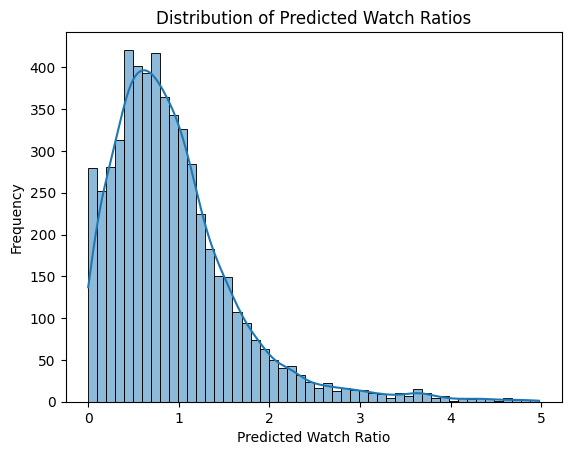

In [139]:
# Actual watch ratio distribution of first users with encoded IDs 0, 1, 2
test2 = train_ohe
test2['user_idx'] = dataset_train.user_encoder.transform(test2['user_id'])

test2 = test2[test2['user_idx'] < 3]

sns.histplot(test2['watch_ratio'], bins=50, kde=True)
plt.title("Distribution of Predicted Watch Ratios")
plt.xlabel("Predicted Watch Ratio")
plt.ylabel("Frequency")
plt.show()

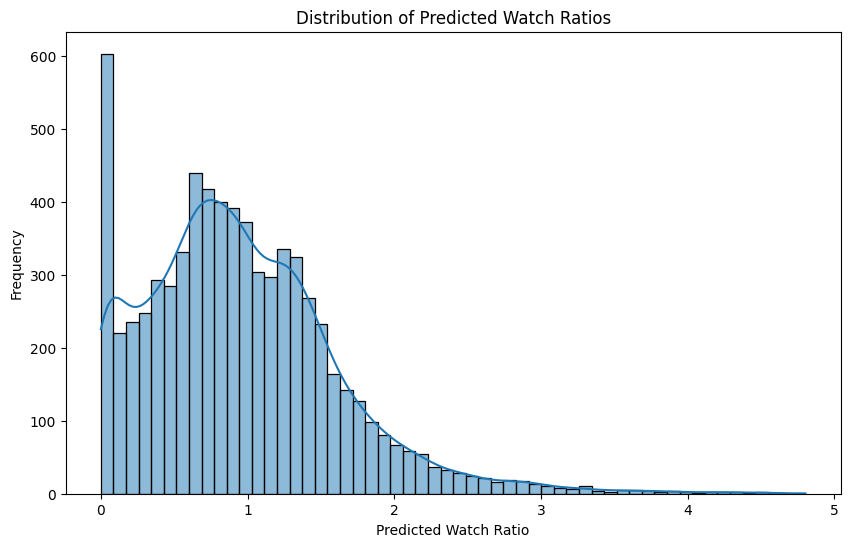

In [261]:
plt.figure(figsize=(10, 6))
sns.histplot(watch_ratio_df['watch_ratio'], kde=True)
plt.title("Distribution of Predicted Watch Ratios")
# plt.xlim(0, 5)
plt.xlabel("Predicted Watch Ratio")
plt.ylabel("Frequency")
plt.show()